In [225]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate, stats

from regression_functions.metrics_tracker import MetricsTracker
from regression_functions.predictor import Predictor


def create_target_df(df:pd.DataFrame, name_x, name_y):
    # 결측치 있는 부분 제거.
    df = df[[name_x, name_y]].dropna().sort_values(name_x)
    # x 축에 대하여 이상치 제거.
    zscore_x = stats.zscore(df[name_x])
    df = df[zscore_x.between(-2,2)] # 95퍼센트 신뢰구간 안에 있는 데이터만 사용.
    # y 축에 대하여 이상치 제거.
    zscore_y = stats.zscore(df[name_y])
    df = df[zscore_y.between(-2,2)]
    # 이상치 제거 완료된 데이터를 ndarray로 바꾼 후 오브젝트에 저장.
    target_x = df[name_x].to_numpy().reshape(-1, 1)
    target_y = df[name_y].to_numpy().reshape(-1, 1)
    var = np.var(df[name_y])
    return target_x, target_y, var


class BayesianLinearRegression(Predictor):
    def __init__(self):
        self.m_n = None
        self.s_n = None
        self.likelihood_var = None
        self.degree_x = None

    def train(self, x, y, degree_x, likelihood_var, m_0, s_0):
        # 나중에 필요한 값 저장
        self.degree_x = degree_x
        self.likelihood_var = likelihood_var
        # 설계 행렬 만들기
        design_matrix = x
        for i in range(2,degree_x + 1):
            design_matrix = np.concatenate((design_matrix, pow(x, i)), axis=1)
        bias = np.ones((x.shape[0], 1))
        design_matrix = np.concatenate((bias, design_matrix), axis=1)
        # S_n, m_n 구하기
        inv_s_0 = np.linalg.inv(s_0)
        self.s_n = np.linalg.inv(inv_s_0 + (1 / (likelihood_var**2)) * design_matrix.T.dot(design_matrix))
        self.m_n = self.s_n.dot(inv_s_0.dot(m_0) + (1 / (likelihood_var**2)) * design_matrix.T.dot(y))
        

    def predict(self, x: np.ndarray):
        # 설계 행렬 만들기
        design_matrix = x
        for i in range(2,degree_x + 1):
            design_matrix = np.concatenate((design_matrix, pow(x, i)), axis=1)
        bias = np.ones((x.shape[0], 1))
        design_matrix = np.concatenate((bias, design_matrix), axis=1)
        # 입력 x에 대한 예측 분포의 평균값 구하기
        m = design_matrix.dot(self.m_n).flatten()
        # 입력 x에 대한 예측 분포의 분산 구하기 
        var = np.array(list(map(lambda x: x.dot(self.s_n).dot(x.T) + self.likelihood_var**2, design_matrix)))
        return m, var



ENVRIONMENT_NAME = ['co2', 'dp', 'hd', 'hmdt', 'hmdt_abs', 'hmdt_sat', 'ior', 'temp', 'vpd']
GROWTH_NAME = ['img_growth_length', 'img_stem_diameter', 'img_flower_height', 'img_flower_cluster', 'img_fruit_cluster', 'plant_leaf_length_width_rt', 'plant_leaf_width_length_rt', 'plant_lai', 'plant_flower_height_stem_dia_rt', 'fruit_weight_fresh', 'man_plant_height', 'man_growth_length', 'man_flower_height', 'man_stem_diameter', 'man_fl_cluster', 'man-fr-cluster', 'man_leaf_max_length', 'man_leaf_max_width', 'man_leaf', 'man_flower', 'man_fruit', 'man_fruit_length', 'man_fruit_width']
degree_x = 7
n_sigma = 1
metrics_tracker = MetricsTracker()
BLR = BayesianLinearRegression()



In [226]:
# 데이터셋 생성
name_x = 'dp'
name_y = 'img_flower_cluster'
df = pd.read_csv('2122_plant_sum_week.csv')
x, y, likelihood_var = create_target_df(df, name_x, name_y)
likelihood_var


0.07974575778407915

In [227]:
# 훈련
metrics_tracker.profile(BLR.train, x, y, degree_x, 0.2, np.ones(degree_x + 1).reshape((degree_x + 1, 1)), np.eye(degree_x + 1))


train: 0.00026607513427734375 seconds.


In [228]:
# 추론할 x축 값들 마련
min_x = np.min(x)
max_x = np.max(x)
range_x = np.arange(min_x, max_x, (max_x-min_x)/1000).reshape(-1,1)

In [229]:
# 추론
m, var = metrics_tracker.profile(BLR.predict, range_x)
var

predict: 0.005238771438598633 seconds.


array([0.07883479, 0.07772485, 0.07665754, 0.07563153, 0.07464555,
       0.07369835, 0.07278871, 0.07191542, 0.07107731, 0.07027324,
       0.0695021 , 0.06876279, 0.06805424, 0.06737541, 0.06672529,
       0.06610289, 0.06550722, 0.06493736, 0.06439238, 0.06387137,
       0.06337347, 0.06289782, 0.06244359, 0.06200997, 0.06159616,
       0.06120141, 0.06082496, 0.06046608, 0.06012407, 0.05979824,
       0.05948791, 0.05919245, 0.05891121, 0.05864358, 0.05838896,
       0.05814679, 0.05791649, 0.05769752, 0.05748935, 0.05729147,
       0.05710338, 0.05692461, 0.05675469, 0.05659316, 0.05643959,
       0.05629357, 0.05615468, 0.05602253, 0.05589674, 0.05577695,
       0.05566279, 0.05555394, 0.05545005, 0.05535082, 0.05525594,
       0.05516511, 0.05507806, 0.05499452, 0.05491421, 0.05483691,
       0.05476235, 0.05469033, 0.05462061, 0.05455299, 0.05448727,
       0.05442326, 0.05436076, 0.05429962, 0.05423966, 0.05418073,
       0.05412268, 0.05406537, 0.05400865, 0.05395242, 0.05389

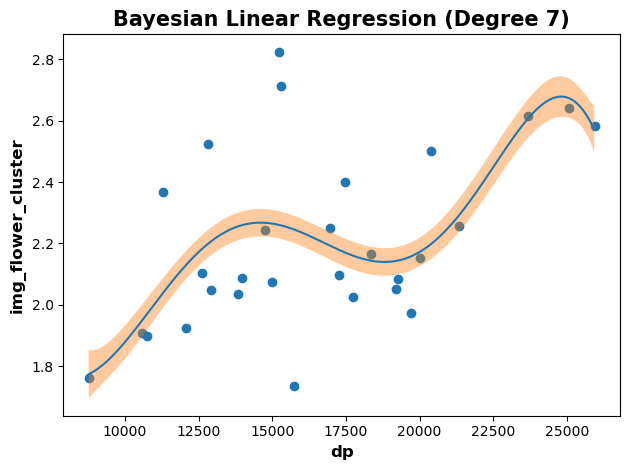

In [230]:
# 그래픽으로 보기
plt.title(f'Bayesian Linear Regression (Degree {degree_x})', fontsize=15, fontweight='bold')
plt.xlabel(f'{name_x}', fontsize=12, fontweight='bold')
plt.ylabel(f'{name_y}', fontsize=12, fontweight='bold')
plt.scatter(x,y)
plt.fill_between(range_x.flatten(), m - n_sigma*var, m + n_sigma*var, alpha=0.4, label=f'{n_sigma} sigma variance')
plt.plot(range_x, m, label='mean of posterior')
plt.tight_layout()
plt.show()